In [33]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

In [34]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [35]:
input_df = pd.read_csv("output.csv")
input_df.describe()

,movie_name,genres
count,199280,199280
unique,173598,1270
top,Broken,['drama']
freq,27,31490


In [36]:
#Get the first five rows of the dataset
input_df.head()

,movie_name,genres
0,Miss Jerry,['romance']
1,Hamlet,['drama']
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']"
3,"Hamlet, Prince of Denmark",['drama']
4,The Life of Moses,"['biography', 'drama', 'family']"


In [37]:
#Get the total number of genres in the dataset
totalGenres = []
allGenres = []
for row in input_df['genres']:
    if row:
        temp = []
        curstr = row[1:-1]
        curGenres = curstr.split(',')
        for eachGenre in curGenres:
            allGenres.append(eachGenre.replace("'", '').strip())
            temp.append(eachGenre.replace("'", '').strip())
        totalGenres.append(temp)
input_df['new_genres'] = totalGenres

input_df.head()


,movie_name,genres,new_genres
0,Miss Jerry,['romance'],[romance]
1,Hamlet,['drama'],[drama]
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","[adventure, fantasy]"
3,"Hamlet, Prince of Denmark",['drama'],[drama]
4,The Life of Moses,"['biography', 'drama', 'family']","[biography, drama, family]"


In [38]:
input_df_new = input_df[~(input_df['new_genres'].str.len() == 0)]
input_df

,movie_name,genres,new_genres
0,Miss Jerry,['romance'],[romance]
1,Hamlet,['drama'],[drama]
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","[adventure, fantasy]"
3,"Hamlet, Prince of Denmark",['drama'],[drama]
4,The Life of Moses,"['biography', 'drama', 'family']","[biography, drama, family]"
...,...,...,...
199275,Liebestraum,['musical'],[musical]
199276,The unknown project title at this time,['comedy'],[comedy]
199277,Minotaur,['thriller'],[thriller]
199278,Coven,"['drama', 'history', 'horror']","[drama, history, horror]"


In [39]:
input_df_new.describe()
# print(allGenres)
# len(allGenres)

,movie_name,genres,new_genres
count,199280,199280,199280
unique,173598,1270,1270
top,Broken,['drama'],[drama]
freq,27,31490,31490


In [40]:
allGenres = nltk.FreqDist(allGenres) 

In [41]:
all_genres_df = pd.DataFrame({'Genre': list(allGenres.keys()), 
                              'Count': list(allGenres.values())})

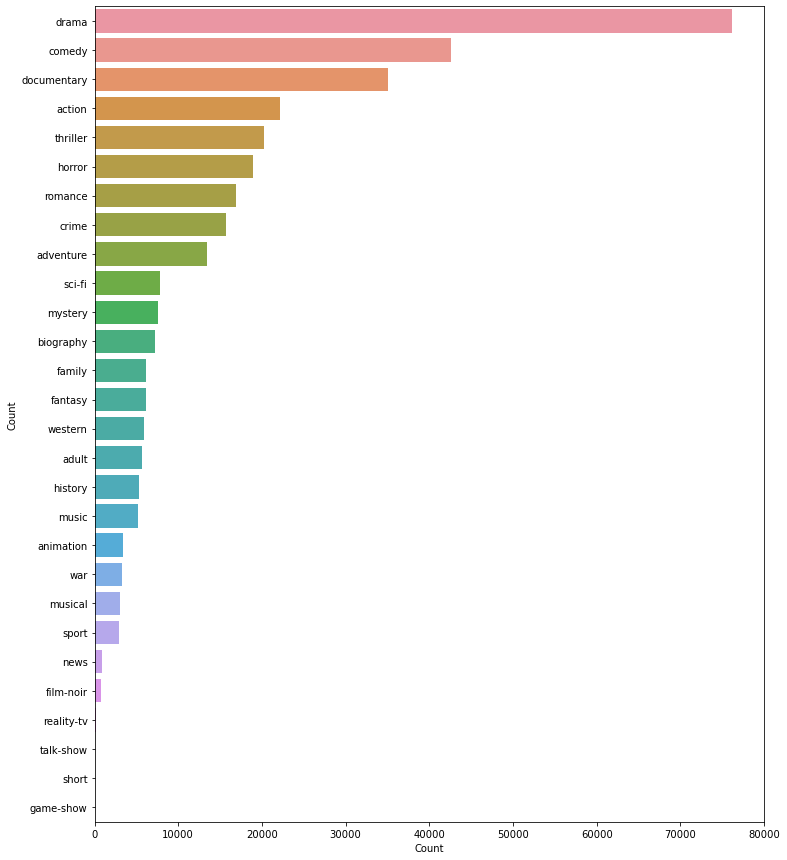

In [42]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [43]:
input_df['movie_name_new'] = input_df['movie_name'].apply(lambda x: clean_text(x))


In [44]:
input_df.head()

,movie_name,genres,new_genres,movie_name_new
0,Miss Jerry,['romance'],[romance],miss jerry
1,Hamlet,['drama'],[drama],hamlet
2,The Fairylogue and Radio-Plays,"['adventure', 'fantasy']","[adventure, fantasy]",the fairylogue and radio plays
3,"Hamlet, Prince of Denmark",['drama'],[drama],hamlet prince of denmark
4,The Life of Moses,"['biography', 'drama', 'family']","[biography, drama, family]",the life of moses


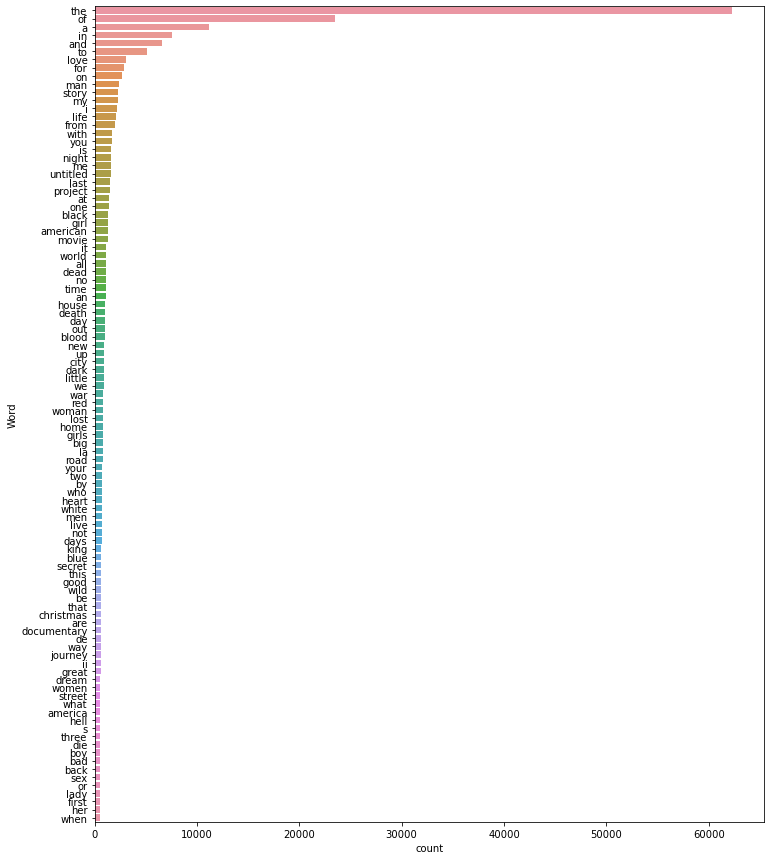

In [45]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(input_df['movie_name_new'], 100)

In [46]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sidharth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

input_df['movie_name_new'] = input_df['movie_name_new'].apply(lambda x: remove_stopwords(x))

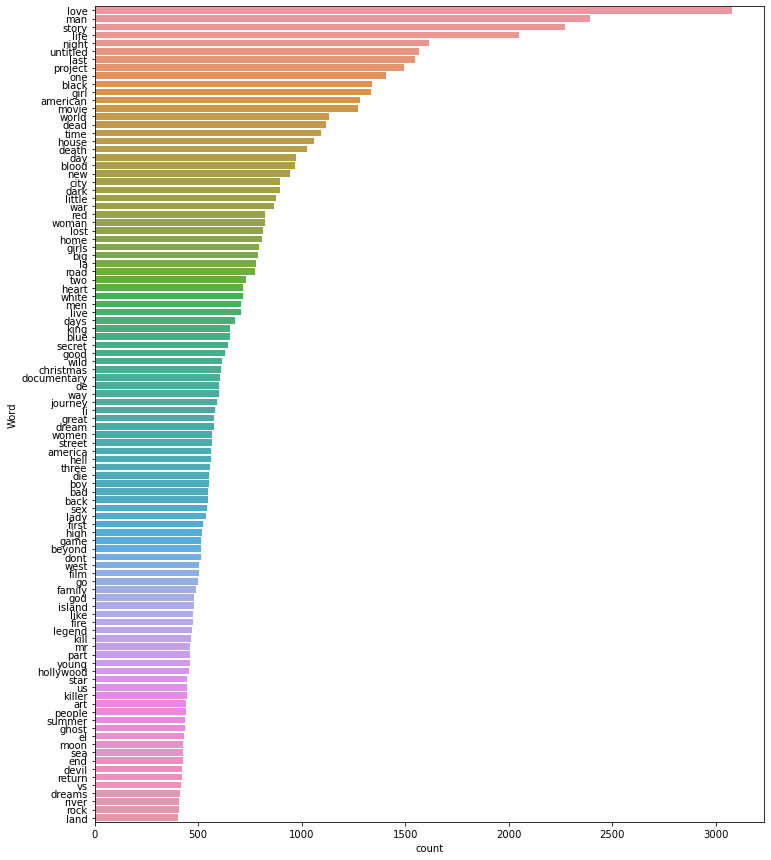

In [48]:
freq_words(input_df['movie_name_new'], 100)

In [49]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(input_df['new_genres'])

# transform target variable
y = multilabel_binarizer.transform(input_df['new_genres'])

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)


In [51]:
xtrain, xval, ytrain, yval = train_test_split(input_df['movie_name_new'], y, test_size=0.01)


In [52]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [53]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [54]:
lr = LogisticRegression(max_iter=10000)
clf = OneVsRestClassifier(lr)

In [55]:
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))

In [56]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [57]:
y_pred[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [58]:
multilabel_binarizer.inverse_transform(y_pred)[1]


()

In [59]:
f1_score(yval, y_pred, average="micro")

0.1944235116804823

In [60]:
y_pred_prob = clf.predict_proba(xval_tfidf)

In [61]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [62]:
f1_score(yval, y_pred_new, average="micro")

0.38916172734970367

In [63]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [66]:
for i in range(5): 
  k = xval.sample(1).index[0] 
  print("Movie: ", input_df['movie_name'][k], "\nPredicted genre: ", infer_tags(xval[k])), print("Actual genre: ",input_df['new_genres'][k], "\n")


Movie:  The Off Season 
Predicted genre:  [()]
Actual genre:  ['horror'] 

Movie:  Role of a Lifetime 
Predicted genre:  [()]
Actual genre:  ['drama'] 

Movie:  A Whole Lott More 
Predicted genre:  [()]
Actual genre:  ['documentary'] 

Movie:  La Devocion 
Predicted genre:  [()]
Actual genre:  ['drama'] 

Movie:  The Chung Factor 
Predicted genre:  [()]
Actual genre:  ['comedy'] 

